In [2]:
import numpy as np
import jax.numpy as jnp
import jax
import math

from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial, latex_polynomial
from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, taylor_expand_2d, matching_coeffs, build_powers, reduce_order

from utils.distribution_utils import q

from utils.qcd_utils import running_coupling   


# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot, hist_with_errors


In [3]:
# JAX vmapping and compilation
jitted_q  = jax.jit(q)
vmapped_q = jax.vmap(jitted_q, in_axes=(0, None, None, None))

jitted_polynomial = jax.jit(polynomial)
vmapped_polynomial = jax.vmap(jitted_polynomial, in_axes=(0, None))

In [93]:
import numpy as np
import jax.numpy as jnp
import jax
import math
from jax.scipy.signal import convolve2d


# #################################
# ########## POLYNOMIALS ##########
# #################################

# Necessary for jax to work with 0^0@jax.jit
def build_powers(base, length):
   
    def body_fun(i, arr):
        # arr[i] = arr[i-1] * base
        return arr.at[i].set(arr[i-1] * base)
    
    # Initialize an array of zeros, then set arr[0] = 1
    arr = jnp.zeros((length,) ,  dtype = jnp.array(base).dtype)
    arr = arr.at[0].set(1.0)
    
    # fori_loop will fill in arr[1], arr[2], ... arr[length-1]
    arr = jax.lax.fori_loop(1, length, body_fun, arr)
    return arr


@jax.jit
def polynomial(t, alpha, params):

    M, N = params.shape
    
    # Build powers of alpha: [1, alpha, alpha^2, ... alpha^(M-1)]
    alpha_powers = build_powers(alpha, M)  # shape (M,)

    # Build powers of t: [1, t, t^2, ... t^(N-1)]
    t_powers = build_powers(t, N)         # shape (N,)

    poly_val = alpha_powers @ params @ t_powers
    return poly_val

# Multiply two 2D polynomials using their coefficient arrays
def polynomial_multiply(c1, c2, M = None, N = None):

    if M is None:
        M = c1.shape[0] + c2.shape[0]
    if N is None:
        N = c1.shape[1] + c2.shape[1]

    full_conv = convolve2d(c1, c2, mode='full')
    truncated = full_conv
    return truncated



@jax.jit
def polynomial_sum(cs):

    # zero pad to the same size
    max_M = max([c.shape[0] for c in cs])
    max_N = max([c.shape[1] for c in cs])

    for i in range(len(cs)):
        M = cs[i].shape[0]
        N = cs[i].shape[1]
        cs[i] = jnp.pad(cs[i], ((0, max_M - M), (0, max_N - N)), mode='constant')

    cs = jnp.array(cs)
    return jnp.sum(cs, axis=0)


def polynomial_power(c, k):
    
    if k == 0:
        return jnp.array([[1,]])
    elif k == 1:
        return c
    else:
        return polynomial_multiply(c, polynomial_power(c, k-1))


# Debug Tool
def print_polynomial(c):

    # Print the polynomial in a human-readable grid.
    M, N = c.shape
    for m in range(M):
        s = ""
        for n in range(N):
            s += f"c_{m},{n} = {c[m, n]:.2e} "
        print(s)

            

def latex_polynomial(c, eps = 1e-6):


    # Print the polynomial in a latex-readable grid using pmatrix
    M, N = c.shape
    s = "\\begin{pmatrix}\n"
    for m in range(M):
        for n in range(N):

            # Check if the coefficient is close to an integer
            cmn = c[m, n]
            if cmn - eps <= round(cmn) <= cmn + eps:
                cmn = round(cmn)
                s+= f"{int(cmn)} "
            else:
                s += f"{c[m, n]:.2e} "
            if n < N - 1:
                s += "& "
        if m < M - 1:
            s += "\\\\ \n"
        else:
            s += "\\end{pmatrix}\n"
    return s



def reduce_order(c_mn):

    M, N = c_mn.shape
    epsilon = 1e-3

   

    

    first_nonzero_m = 0
    for m in range(M):
        if np.any(np.abs(c_mn[m, :]) > epsilon):
            first_nonzero_m = m
            break

    print("first_nonzero_m", first_nonzero_m)


    first_nonzero_n = 0
    for n in range(N):
        if np.any(np.abs(c_mn[first_nonzero_m:, n]) > epsilon):
            first_nonzero_n = n
            break


    lowest_order_coeff = c_mn[first_nonzero_m, first_nonzero_n]

    if np.abs(lowest_order_coeff) < epsilon:
        lowest_order_coeff = 1.0

    return c_mn[first_nonzero_m:, first_nonzero_n:] / lowest_order_coeff, first_nonzero_m, first_nonzero_n, lowest_order_coeff


def collapse_in_alpha(alpha, c_mn):

    M, N = c_mn.shape
    alpha_powers = build_powers(alpha, M)

    return alpha_powers @ c_mn 



# ##############################
# ########## CALCULUS ##########
# ##############################


def taylor_expand_in_alpha(function, order):

    ps = [function,]
    if order > 0:
        for i in range(order):
            ps.append(jax.grad(ps[-1], argnums=1))

    # Build the Taylor expansion
    return_list = []
    for i in range(order+1):

        def order_n(x, alpha, params, i = i):

            near_zero = 1e-16
            factorial = jax.scipy.special.gamma(i + 1)
            return ps[i](x, near_zero, params) / factorial * jnp.power(alpha, i)
        
        return_list.append(order_n)

    return return_list


def eval_taylor_expansion(taylor_expansion_list, x, alpha, params):

    # Evaluate the Taylor expansion at x and alpha
    result = 0.0
    for i in range(len(taylor_expansion_list)):
        result += taylor_expansion_list[i](x, alpha, params)

    return result



def reduce_alpha(p_m):

    NUM_TRIALS = 1000
    epsilon = 1e-6

    M = len(p_m)

    # Find the first non-zero function in p_m
    first_nonzero_m = 0
    ts = np.linspace(0, 1, NUM_TRIALS)

    for m in range(M):
        func = jax.vmap(p_m[m], in_axes=(0, None, None))
        if np.any(np.abs(func(ts, 1, None)) > epsilon):
            first_nonzero_m = m
            break
    
    p_star = p_m[first_nonzero_m]
    p_m = p_m[first_nonzero_m:]
    r_m = []

    # Normalize each function in p_m by dividing by p_star
    for m in range(len(p_m)):
        
        def p_m_func(t, alpha, params, m = m):
            return p_m[m](t, alpha, params) / p_star(t, alpha, params)
        
        r_m.append(p_m_func)

    return r_m, p_star, first_nonzero_m


# Given a function f(t, alpha, params), compute the Taylor coefficients f(t, alpha) \approx \sum_{mn} c_{mn} alpha^m t^n 
def taylor_expand_2d(f, t0, alpha0, M, N, params=None):
    

    # Make a helper that has the right signature for JAX differentiation.
    def f_base(t, alpha):
        return f(t, alpha, params)

    # Build partial derivatives wrt t in a list f_list[n] = (d^n/dt^n) f.

    f_list = [f_base]      # f_0
    for n_ in range(N):
        fn_plus_1 = jax.grad(f_list[-1], argnums=0)  # derivative wrt t
        f_list.append(fn_plus_1)

    # For each f_list[n], we get all derivatives wrt alpha at alpha0,    
    c = jnp.zeros((M+1, N+1), dtype=jnp.float32)

    def derivatives_wrt_alpha_up_to_order_M(fn_of_alpha, alpha0, M):
        """
        Return [ fn_of_alpha^{(0)}(alpha0), 
                 fn_of_alpha^{(1)}(alpha0),
                 ...
                 fn_of_alpha^{(M)}(alpha0) ] 
        by repeated application of jax.grad wrt alpha (argnums=0).
        """
        out = []
        current_g = fn_of_alpha
        for m_ in range(M+1):
            if m_ == 0:
                # 0th derivative => the function value
                out.append(current_g(alpha0))
            else:
                # 1st..Mth => derivative wrt alpha
                current_g = jax.grad(current_g, argnums=0)
                out.append(current_g(alpha0))
        return jnp.array(out)

    # Loop over n=0..N
    for n_ in range(N+1):
        # The function f_n(t, alpha)
        fn = f_list[n_]

        def fn_of_alpha(a):
            return fn(t0, a)

        # partials_alpha[m] = (d^m / dalpha^m) fn(t0, alpha) at alpha=alpha0
        partials_alpha = derivatives_wrt_alpha_up_to_order_M(fn_of_alpha, alpha0, M)
        # partials_alpha[m] = (∂^(m+n_)/∂t^n_ ∂alpha^m) f  at (t0, alpha0)

        # Fill c[m, n_] = partials_alpha[m] / (m! n_!)
        for m_ in range(M+1):
            val = partials_alpha[m_]
            denom = math.factorial(m_) * math.factorial(n_)
            c = c.at[m_, n_].set(val / denom)

    return c


def log_match(c_mn, M, N):

    K = M + N

    polynomial_coeffs = polynomial_sum([polynomial_power(c_mn, k+1) / (k+1.0) for k in range(K+1)])
    return polynomial_coeffs[:M+1, :N+1]



def matching_coeffs(p_t, M, N):

    # There has to be *some* perturbative info!
    if M == 0:
        raise ValueError("M must be greater than 0")
 
    
    p_mn = taylor_expand_2d(p_t, 0.0, 0.0, M, N)
    P_mn = integrate_taylor_polynomial(p_mn)

    # print("p_mn")
    # print_polynomial(p_mn)
    # print("P_mn")
    # print_polynomial(P_mn)
    # print("")


    # Divide out the lowest order term of p_mn
    p_mn_reduced, m_star, n_star, p_star = reduce_order(p_mn)
    p_mn_reduced = p_mn_reduced.at[0, 0].set(0.0)

    p_matched = log_match(-p_mn_reduced, M, N)
    # p_matched = log_match(-p_mn_reduced, M - m_star, N-n_star)
    P_matched = log_match(P_mn, M, N) 

    # print("p_matched")
    # print_polynomial(p_matched)
    # print("P_matched")
    # print_polynomial(P_matched)
    # print("")


    g_mn = polynomial_sum([-p_matched, P_matched])
    g_star = jnp.zeros((M+1, N+1))
    g_star = g_star.at[m_star, n_star].set(-p_star)

    return g_mn, g_star

r_m 1


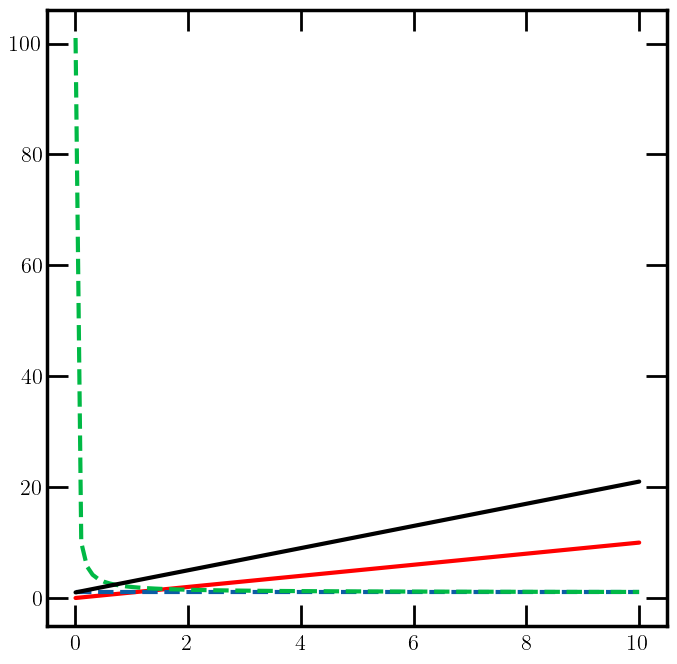

In [102]:
def p_t(t, alpha, param):

    alpha_bar = alpha #* 4/3 / jnp.pi
    order_0 = 0
    order_1 = alpha_bar * t
    order_2 = alpha_bar**2 * (t + 1)

    return order_0 + order_1  + order_2 


alpha = 1
ts = np.linspace(0.01, 10, 100)

# p_t = jax.vmap(p_t, in_axes=(0, None, None))
p_m = (taylor_expand_in_alpha(p_t, 2))

r_m, p_star, m_star = reduce_alpha(p_m)
print("r_m", m_star)

p_star = jax.vmap(p_star, in_axes=(0, None, None))
plt.plot(ts, p_star(ts, alpha, None), label = "p_star", color = "red") 

for i in range(len(r_m)):
    r = jax.jit(jax.vmap(r_m[i], in_axes=(0, None, None)))
    plt.plot(ts,  r(ts, alpha, None), label = f"r_m{i}", ls = "--")

# plt.yscale('log')

# p_m0 = jax.vmap(p_m[0], in_axes=(0, None, None))
# p_m1 = jax.vmap(p_m[1], in_axes=(0, None, None))
# p_m2 = jax.vmap(p_m[2], in_axes=(0, None, None))
# vmapped_eval_taylor = jax.vmap(eval_taylor_expansion, in_axes=(None, 0, None, None))

plt.plot(ts, p_t(ts, alpha, None), label = "p_t", color = "black")
# plt.plot(ts, p_m0(ts, alpha, None), label = "p_m0", ls = "--")
# plt.plot(ts, p_m1(ts, alpha, None), label = "p_m1", ls = "--")
# plt.plot(ts, p_m2(ts, alpha, None), label = "p_m2", ls = "--")
# plt.plot(ts, vmapped_eval_taylor(p_m, ts, alpha, None), label = "p_m0 eval", ls = "--")


In [43]:
def p_t(t, alpha, param):

    alpha_bar = alpha #* 4/3 / jnp.pi
    order_0 = 0
    order_1 = alpha_bar * t
    order_2 = alpha_bar**2 * (t + 1)

    return order_0 + order_1  + order_2 

p_mn = taylor_expand_2d(p_t, 0.0, 0.0, 2, 2, 0)



def identify_sublock(c_mn, epsilon=1e-3):

    M, N = c_mn.shape

    # Find the first non-zero row
    first_nonzero_m = 0
    for m in range(M):
        if np.any(np.abs(c_mn[m, :]) > epsilon):
            first_nonzero_m = m
            break

    # Find the first non-zero column
    first_nonzero_n = 0
    for n in range(N):
        if np.any(np.abs(c_mn[:, n]) > epsilon):
            first_nonzero_n = n
            break

    subblock = c_mn[:first_nonzero_m+1, :first_nonzero_n+1]

    print("first_nonzero_m", first_nonzero_m)
    print("first_nonzero_n", first_nonzero_n)

    return subblock


print("p_mn")
print_polynomial(p_mn)

print("subblock")
subblock = identify_sublock(p_mn)
print_polynomial(subblock)

p_mn
c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 
c_1,0 = 0.00e+00 c_1,1 = 1.00e+00 c_1,2 = 0.00e+00 
c_2,0 = 1.00e+00 c_2,1 = 1.00e+00 c_2,2 = 0.00e+00 
subblock
first_nonzero_m 1
first_nonzero_n 0
c_0,0 = 0.00e+00 
c_1,0 = 0.00e+00 


first_nonzero_m 1
c_0,0 = 0.00e+00 c_0,1 = 1.00e+00 c_0,2 = -5.00e-01 
c_1,0 = 1.00e+00 c_1,1 = 0.00e+00 c_1,2 = 5.00e-01 
c_2,0 = -5.00e-01 c_2,1 = 1.00e+00 c_2,2 = 5.00e-01 
c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 
c_1,0 = -1.00e+00 c_1,1 = 0.00e+00 c_1,2 = 0.00e+00 
c_2,0 = 0.00e+00 c_2,1 = 0.00e+00 c_2,2 = 0.00e+00 


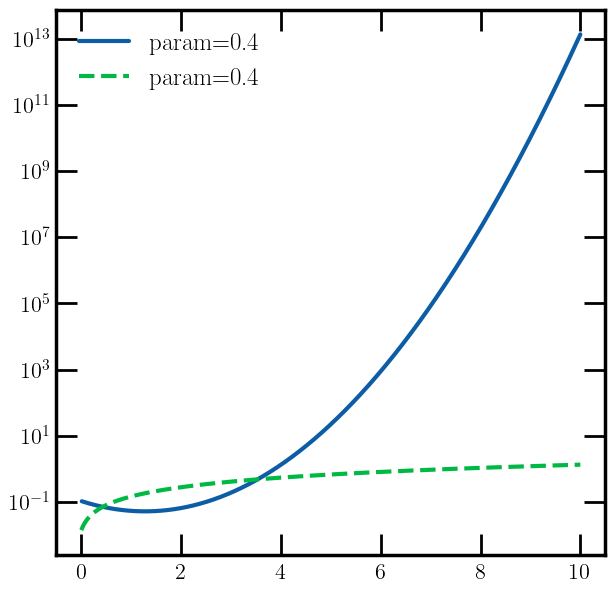

In [40]:
g_mn, g_star = matching_coeffs(p_t, 2, 2)

# g_mn = g_mn.at[2, 0].set(0)

# g_mn[0, 2] = 0


print_polynomial(g_mn)
print_polynomial(g_star)

alpha = 0.118
t = np.linspace(0, 10, 1000)
qs = vmapped_q(t, alpha, g_star, g_mn)

fig, ax = newplot("full")
# Plot the function for different parameter values
ax.plot(t, qs, label=f'param={param}')
ax.plot(t, p_t(t, alpha, 0), label=f'param={param}', linestyle='--')

plt.yscale('log')



ax.legend()

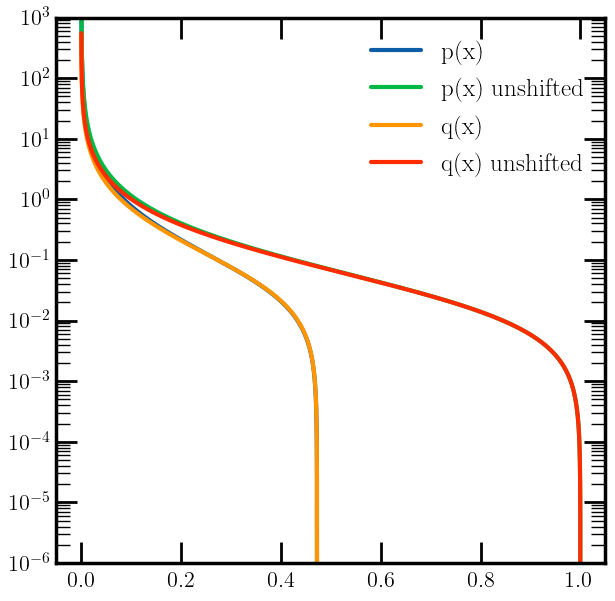

In [11]:
def p_x(x, alpha, params):

    alpha_bar = alpha * 4/3 / jnp.pi
    return alpha_bar * (jnp.log(1/x) - 3/4) / x


def p_x_unshifted(x, alpha, params):

    alpha_bar = alpha * 4/3 / jnp.pi
    return alpha_bar * (jnp.log(1/x) ) / x


def q_x(x, alpha, params):

    alpha_bar = alpha * 4/3 / jnp.pi
    return p_x(x, alpha, params) * jnp.exp(-alpha_bar / 2 * (jnp.log(1/x)**2 - 3/2))

def q_x_unshifted(x, alpha, params):

    alpha_bar = alpha * 4/3 / jnp.pi
    return p_x_unshifted(x, alpha, params) * jnp.exp(-alpha_bar / 2 * (jnp.log(1/x)**2 ))


xs = jnp.linspace(0.000, 1, 10000)

fig, ax = newplot("full")
alpha = 0.118
ax.plot(xs, p_x(xs, alpha, None), label="p(x)")
ax.plot(xs, p_x_unshifted(xs, alpha, None), label="p(x) unshifted")

ax.plot(xs, q_x(xs, alpha, None), label="q(x)")
ax.plot(xs, q_x_unshifted(xs, alpha, None), label="q(x) unshifted")


plt.yscale("log")
plt.ylim(1e-6, 1e3)
ax.legend()
